In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from matplotlib import gridspec
from scipy import corrcoef, stats
from scipy.stats.kde import gaussian_kde
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use("arviz-darkgrid")

# Chapter 5 - Some examples of data analysis
## 5.1 Pearson correlation


The Pearson product-moment correlation coefficient, usually denoted r, is a widely used measure of the relationship between two variables. It ranges from −1, indicating a perfect negative linear relationship, to +1, indicating a perfect positive relationship. A value of 0 indicates that there is no linear relationship. Usually the correlation r is reported as a single point estimate, perhaps together with a frequentist significance test.

But, rather than just having a single number to measure the correlation, it would be nice to have a posterior distribution for r, saying how likely each possible level of correlation was. There are frequentist confidence interval methods that try to do this, as well as various analytic Bayesian results based on asymptotic approximations (e.g., Donner & Wells, 1986).


Inferring the mean and variance of a Gaussian distribution. 
$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (-1, 1) $$  
$$ x_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1})  $$

The observed data take the form _x<sub>i</sub> = (_x<sub>i1</sub>_, _x<sub>i2</sub>_) for the ith observation, and, following the theory behind the correlation coefficient, are modeled as draws from a multivariate Gaussian distribution. The parameters of this distribution are the means _μ_ = (_μ<sub>1</sub>_,_μ<sub>2</sub>_) and standard deviations _σ_ = (_σ<sub>1</sub>_,_σ<sub>2</sub>_) of the two variables, and the correlation coefficient _r_ that links them.

**NB: This model runs with PyMC 3.8, but not with the master branch -- probably related to [this issue](https://github.com/pymc-devs/pymc3/issues/3884).**

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda2, lambda1, mu, r]
Sampling 4 chains, 1 divergences: 100%|██████████████████████████████████████| 24000/24000 [00:48<00:00, 496.67draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


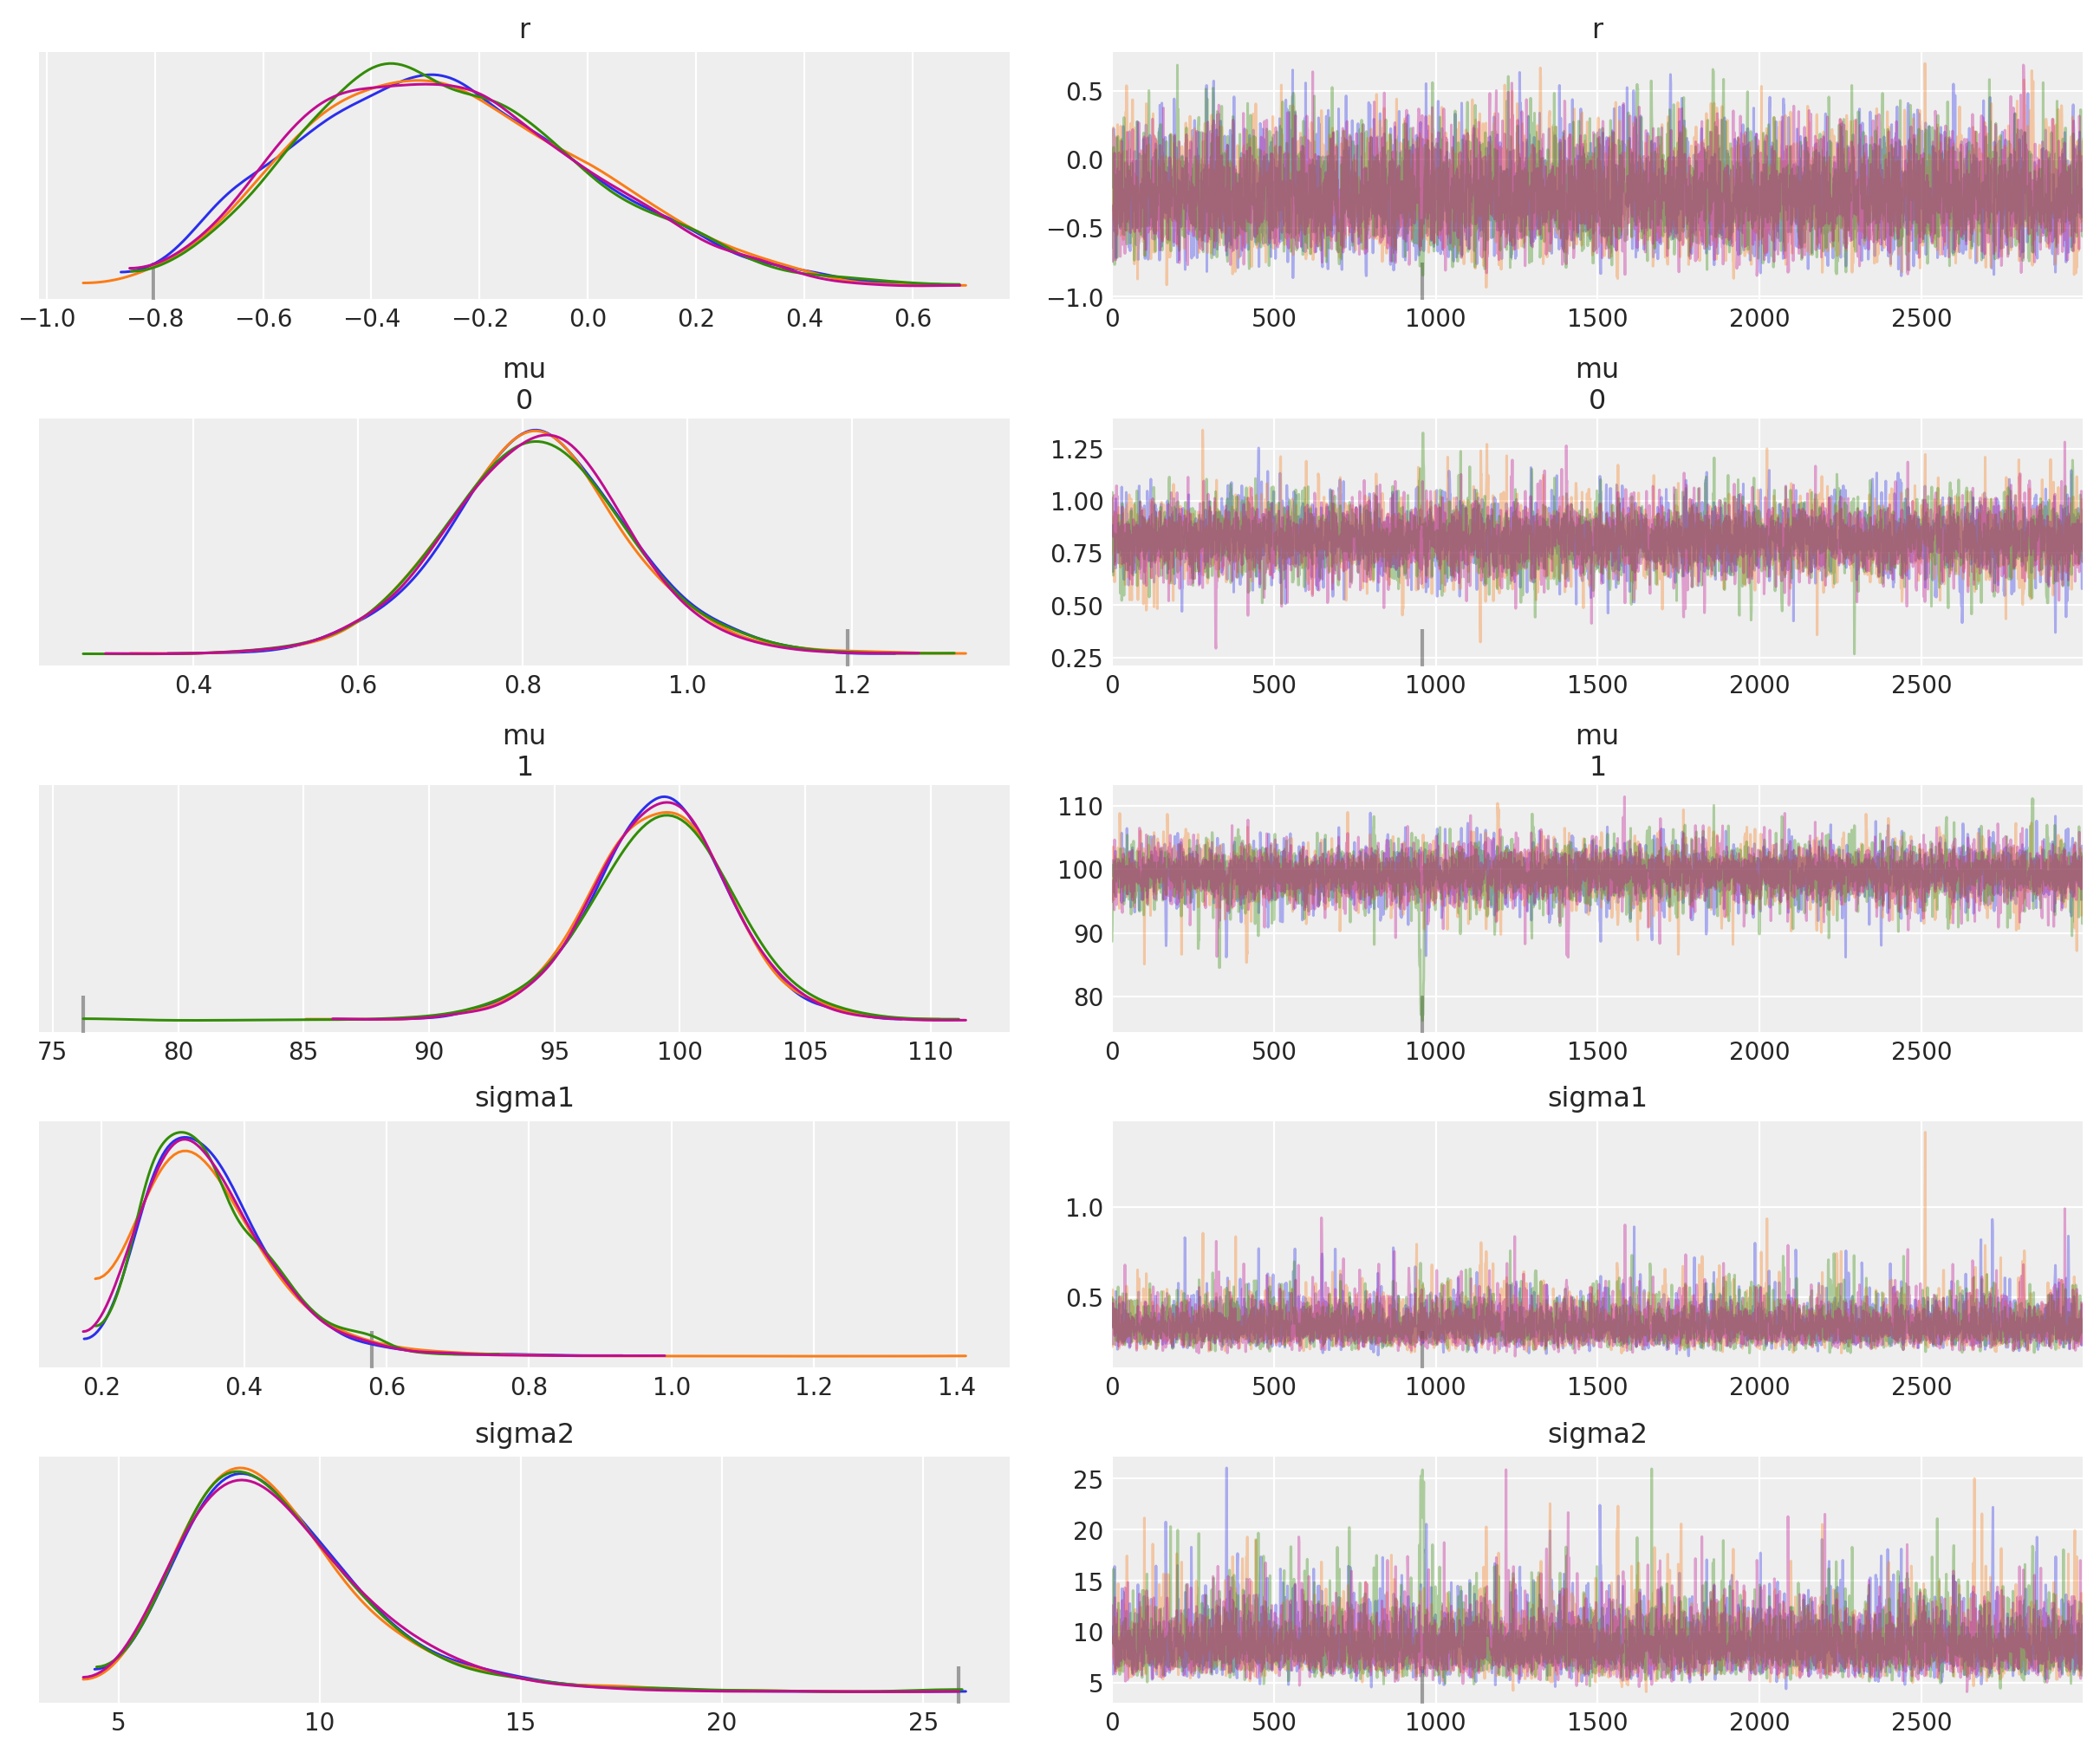

In [3]:
# The datasets:
y = np.array([0.8, 102, 1, 98, 0.5, 100, 0.9, 105, 0.7, 103, 0.4,
              110, 1.2, 99, .4, 87, 0.6, 113, 1.1, 89, 1.3, 93,]).reshape((11, 2))

#y = np.array([.8,102, 1,98, .5,100, 0.9,105, .7,103,
#               0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93,
#               .8,102, 1,98, .5,100, 0.9,105, .7,103,
#               0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93]).reshape((22, 2))

with pm.Model() as model1:
    #  r∼Uniform(−1,1)
    r = pm.Uniform("r", lower=-1, upper=1)

    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal("mu", mu=0, tau=0.001, shape=2)

    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma("lambda1", alpha=0.001, beta=0.001)
    lambda2 = pm.Gamma("lambda2", alpha=0.001, beta=0.001)
    sigma1 = pm.Deterministic("sigma1", 1 / np.sqrt(lambda1))
    sigma2 = pm.Deterministic("sigma2", 1 / np.sqrt(lambda2))

    cov = pm.Deterministic("cov", tt.stacklists(
        [[lambda1 ** -1, r * sigma1 * sigma2], [r * sigma1 * sigma2, lambda2 ** -1]]))

    # xi∼MvGaussian((μ1, μ2),[σ1^2, rσ1σ2; rσ1σ2, σ2^2]^−1)
    yd = pm.MvNormal("yd", mu=mu, cov=cov, observed=y, shape=2)

    trace1 = pm.sample(3000, tune=3000)

az.plot_trace(trace1, var_names=["r", "mu", "sigma1", "sigma2"]);

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: scipy.corrcoef is deprecated and will be removed in SciPy 2.0.0, use numpy.corrcoef instead
  


The r estimation is -0.259
The Pearson correlation r is -0.343


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


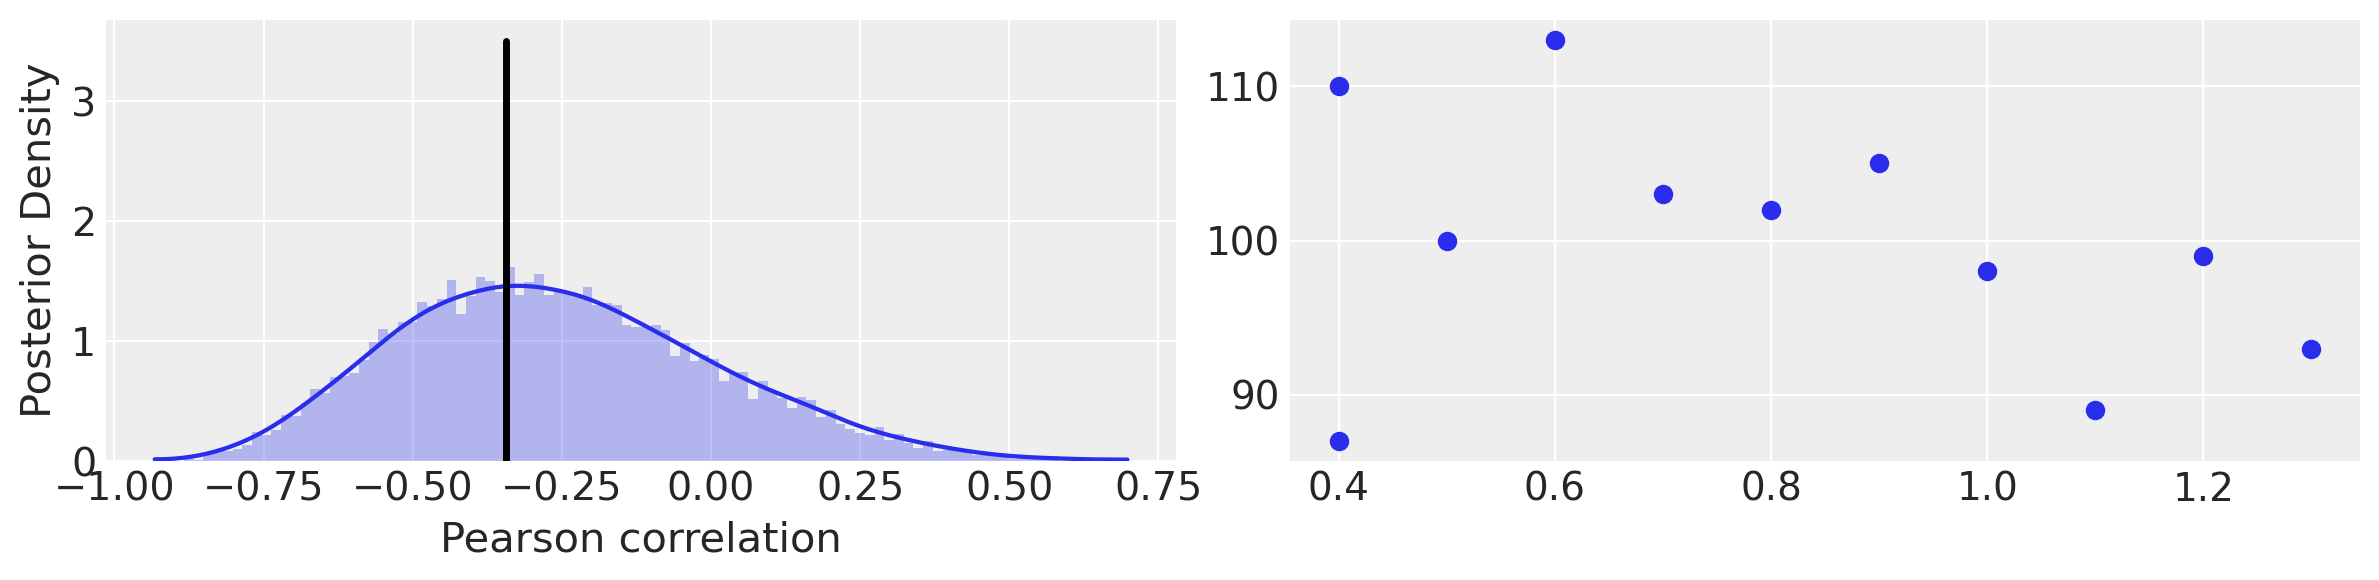

In [4]:
postr = trace1["r"]
freqr = corrcoef(y[:, 0], y[:, 1])
print("The r estimation is %.3f" % postr.mean())
print("The Pearson correlation r is %.3f" % freqr[0, 1])

_, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_kde(postr, ax=axes[0])
axes[0].hist(postr, bins=100, density=1, alpha=0.3)
axes[0].set_xlabel("Rate")
axes[0].set_ylabel("Posterior Density")
axes[0].plot([freqr[0, 1], freqr[0, 1]], [0, 3.5], "k", lw=2.5)
axes[0].set_xlabel("Pearson correlation")
axes[0].set_ylabel("Posterior Density")

axes[1].scatter(y[:, 0], y[:, 1])

plt.tight_layout();

## 5.2 Pearson correlation with uncertainty

  
$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (-1, 1) $$  
$$ y_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1})  $$
$$ x_{ij} \sim \text{Gaussian}(y_{ij},\lambda_{j}^e) $$  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [yd, lambda2, lambda1, mu, r]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 10000/10000 [00:35<00:00, 282.96draws/s]


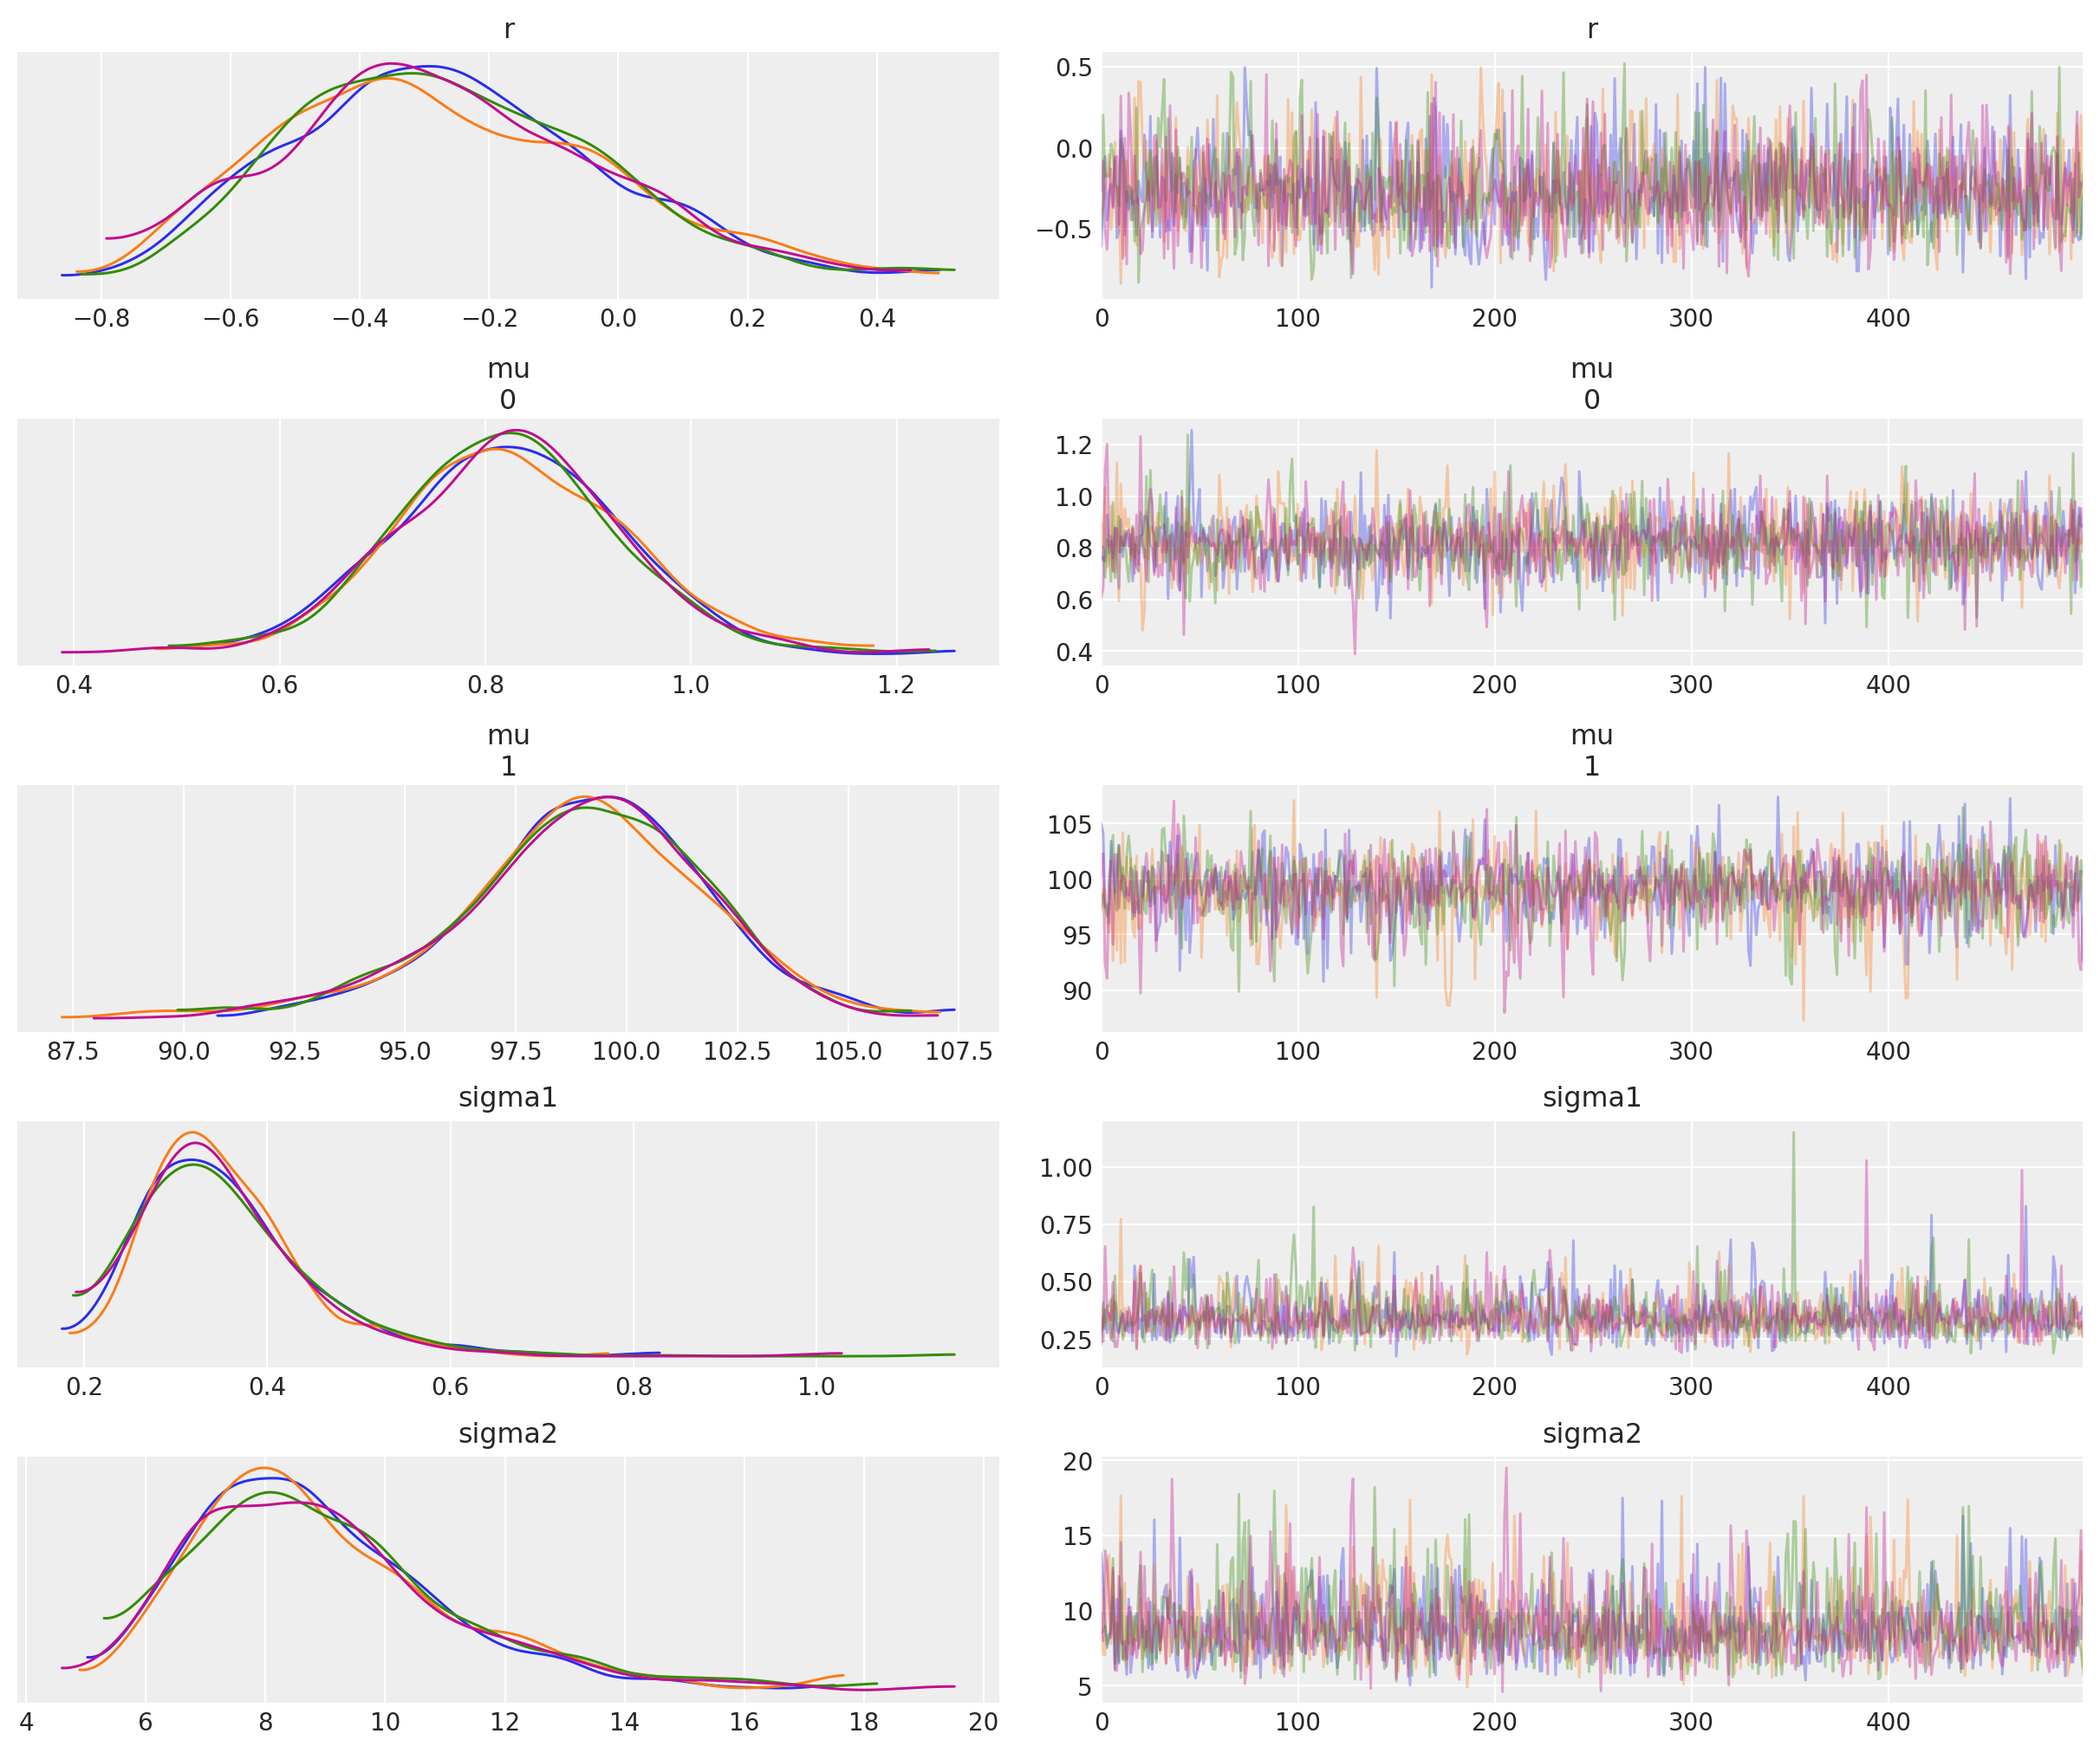

In [5]:
# The datasets:
y = np.array([0.8, 102, 1, 98, 0.5, 100, 0.9, 105, 0.7, 103, 0.4,
              110, 1.2, 99, .4, 87, 0.6, 113, 1.1, 89, 1.3, 93,]).reshape((11, 2))

#y = np.array([.8,102, 1,98, .5,100, 0.9,105, .7,103,
#              0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93,
#              .8,102, 1,98, .5,100, 0.9,105, .7,103,
#              0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93]).reshape((22, 2))

n1, n2 = np.shape(y)
sigmaerror = np.array([0.03, 1])
se = np.tile(sigmaerror, (n1, 1))

with pm.Model() as model2:
    #  r∼Uniform(−1,1)
    r = pm.Uniform("r", lower=-1, upper=1)

    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal("mu", mu=0, tau=0.001, shape=n2)

    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma("lambda1", alpha=0.001, beta=0.001)
    lambda2 = pm.Gamma("lambda2", alpha=0.001, beta=0.001)
    sigma1 = pm.Deterministic("sigma1", 1 / np.sqrt(lambda1))
    sigma2 = pm.Deterministic("sigma2", 1 / np.sqrt(lambda2))

    cov = pm.Deterministic("cov", tt.stacklists(
        [[lambda1 ** -1, r * sigma1 * sigma2], [r * sigma1 * sigma2, lambda2 ** -1]]))

    # xi∼MvGaussian((μ1,μ2),[σ1^2,rσ1σ2;rσ1σ2,σ2^2]^−1)
    yd = pm.MvNormal("yd", mu=mu, cov=cov, shape=(n1, n2))

    xi = pm.Normal("xi", mu=yd, sd=sigmaerror, observed=y) # noise

    trace2 = pm.sample(tune=2000)
    
az.plot_trace(trace2, var_names=["r", "mu", "sigma1", "sigma2"]);

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: scipy.corrcoef is deprecated and will be removed in SciPy 2.0.0, use numpy.corrcoef instead
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


The r estimation is -0.263
The Pearson correlation r is -0.343


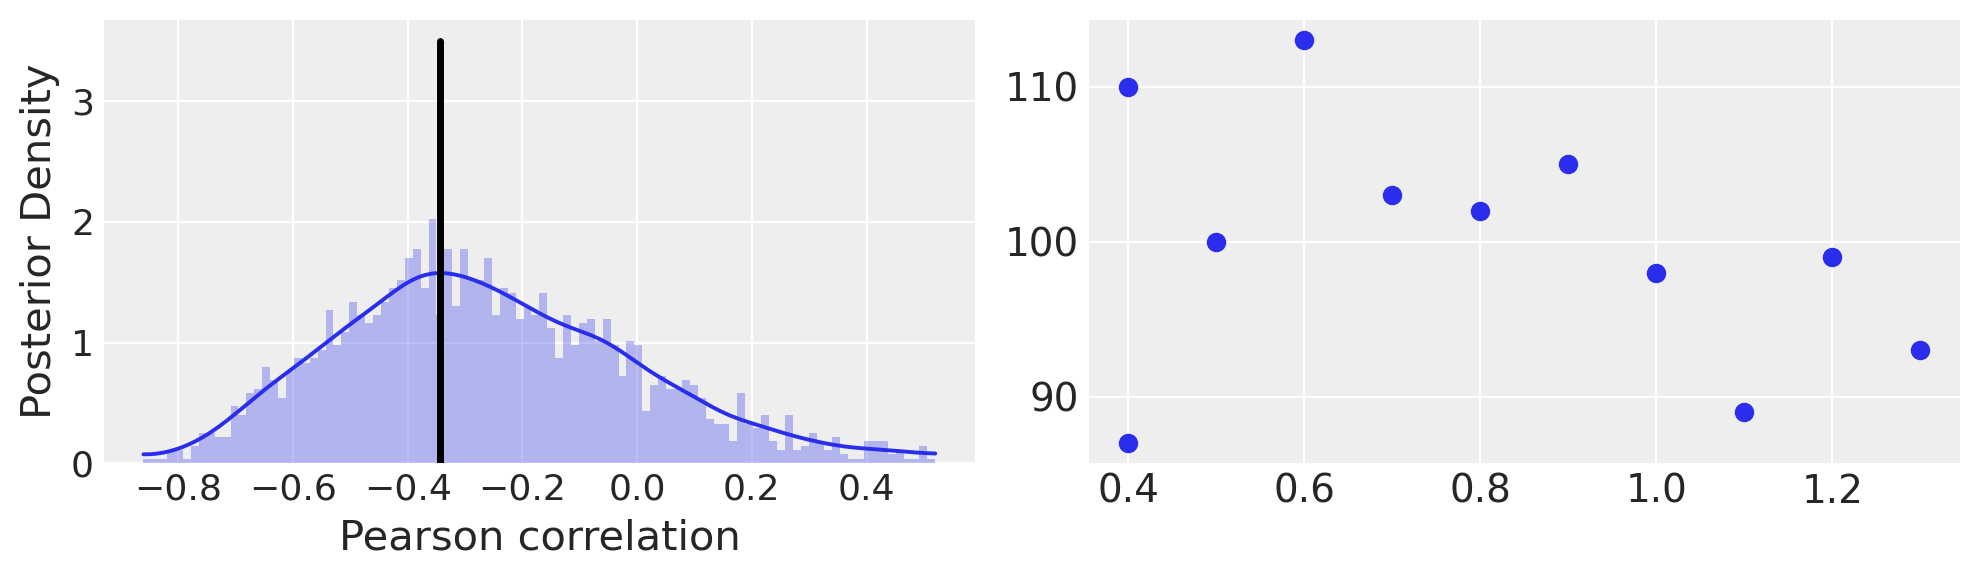

In [6]:
postr = trace2["r"]
freqr = corrcoef(y[:, 0], y[:, 1])
print("The r estimation is %.3f" % postr.mean())
print("The Pearson correlation r is %.3f" % freqr[0, 1])

_, axes = plt.subplots(1, 2, figsize=(10, 3))
az.plot_kde(postr, ax=axes[0])
axes[0].hist(postr, bins=100, density=1, alpha=0.3)
axes[0].set_xlabel("Rate")
axes[0].set_ylabel("Posterior Density")
axes[0].plot([freqr[0, 1], freqr[0, 1]], [0, 3.5], "k", lw=2.5)
axes[0].set_xlabel("Pearson correlation")
axes[0].set_ylabel("Posterior Density")

axes[1].scatter(y[:, 0], y[:, 1])

plt.tight_layout();

## 5.3 The kappa coefficient of agreement
  
A measurement to decide how well one decision-making method agrees with another.
For this problem, when both decision-making methods make n independent assessments, the data y take the form of four counts: a observations where both methods decide “one,” b observations where the objective method decides “one” but the surrogate method decides “zero,” c observations where the objective method decides “zero” but the surrogate method decides “one,” and d observations where both methods decide “zero,” with n = a + b + c + d.

$$ \kappa = (\xi-\psi)/(1-\psi)  $$
$$ \xi = \alpha\beta + (1-\alpha) \gamma  $$
$$ \psi = (\pi_{a}+\pi_{b})(\pi_{a}+\pi_{c})+(\pi_{b}+\pi_{d})(\pi_{c}+\pi_{d})  $$
$$ \alpha,\beta,\gamma \sim \text{Beta} (1, 1) $$  
$$ \pi_{a} = \alpha\beta  $$ 
$$ \pi_{b} = \alpha(1-\beta)  $$  
$$ \pi_{c} = (1-\alpha)(1-\gamma)  $$  
$$ \pi_{d} = (1-\alpha)\gamma  $$  
$$ y \sim \text{Multinomial} ([\pi_{a},\pi_{b},\pi_{c},\pi_{d}],n)  $$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 10000/10000 [00:11<00:00, 876.64draws/s]


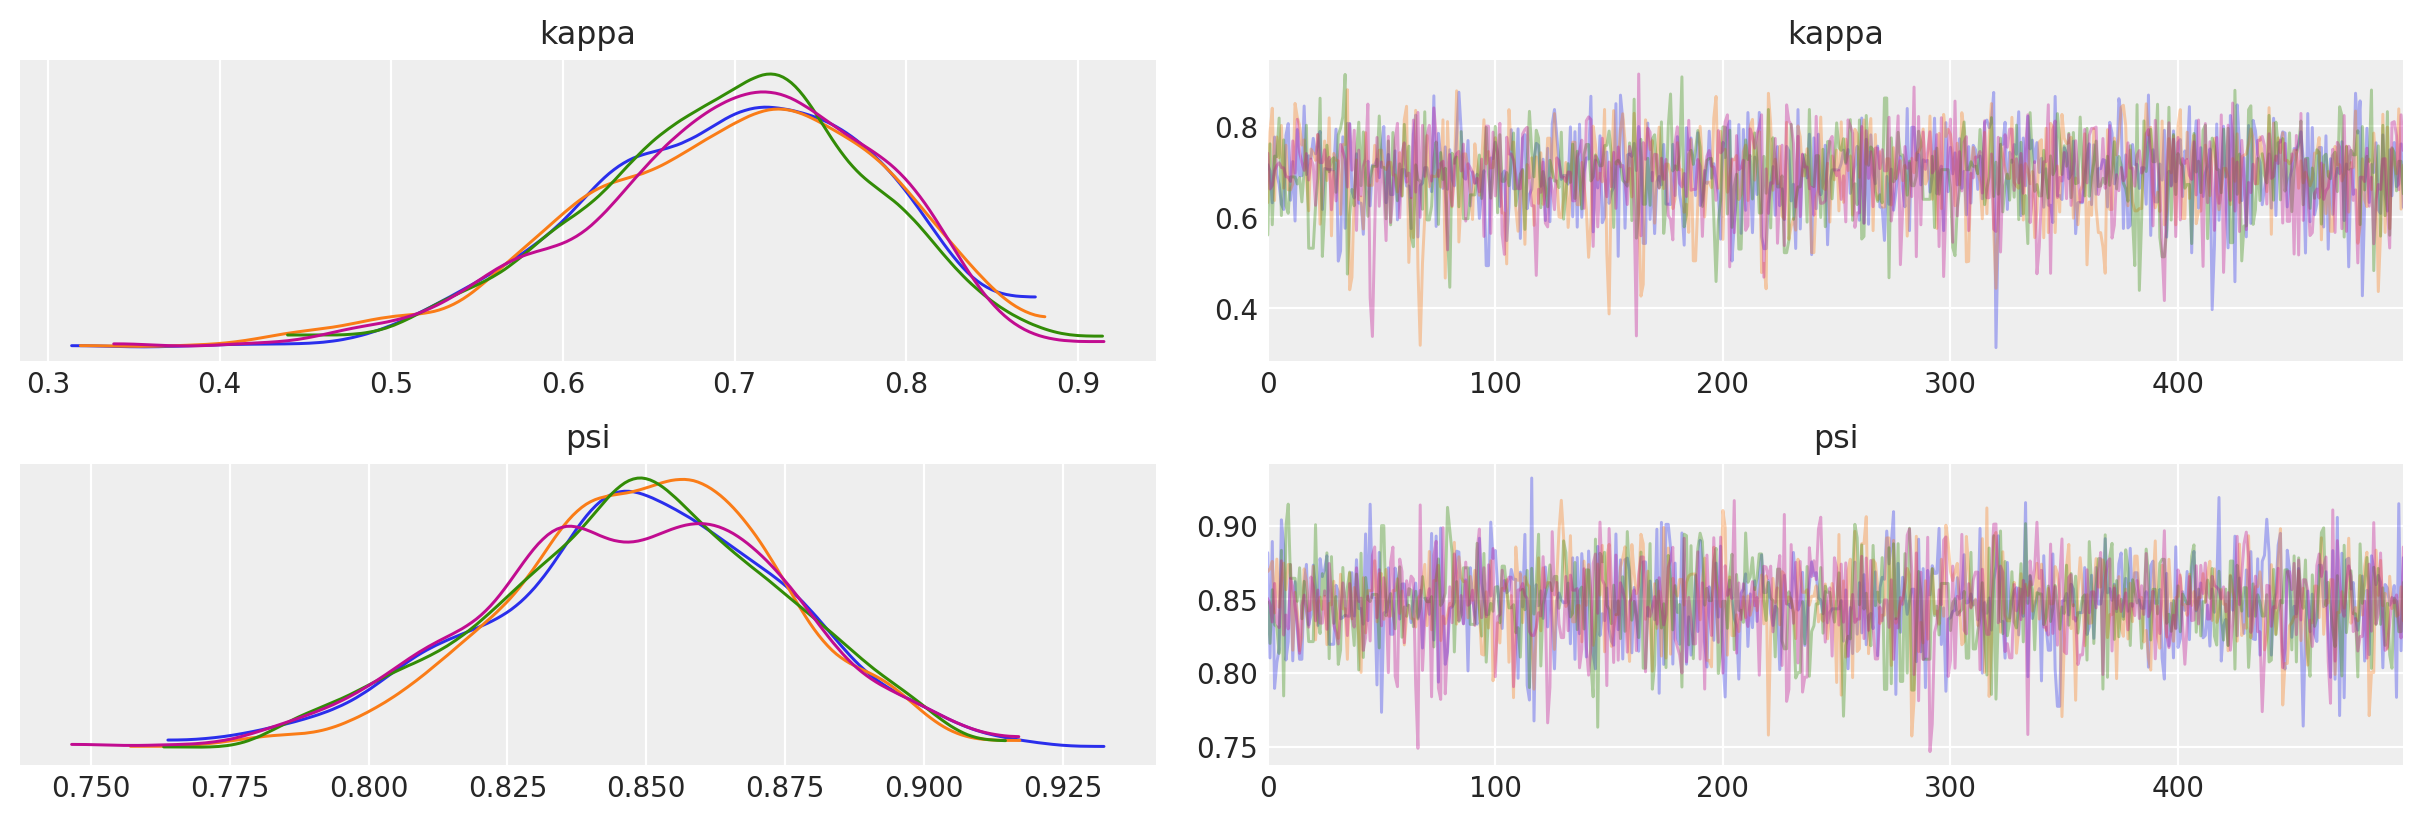

In [7]:
# CHOOSE a data set:
# Influenza
y = np.array([14, 4, 5, 210])

# Hearing Loss
#y = np.array([20, 7, 103, 417])

# Rare Disease
#y = np.array([0, 0, 13, 157])

with pm.Model() as model3:
    # prior
    alpha = pm.Beta("alpha", alpha=1, beta=1)
    beta = pm.Beta("beta", alpha=1, beta=1)
    gamma = pm.Beta("gamma", alpha=1, beta=1)

    pi1 = alpha * beta
    pi2 = alpha * (1 - beta)
    pi3 = (1 - alpha) * (1 - gamma)
    pi4 = (1 - alpha) * gamma

    # Derived Measures
    # Rate Surrogate Method Agrees With the Objective Method
    xi = alpha * beta + (1 - alpha) * gamma

    yd = pm.Multinomial("yd", n=y.sum(), p=[pi1, pi2, pi3, pi4], observed=y)

    # Rate of Chance Agreement
    psi = pm.Deterministic("psi", (pi1 + pi2) * (pi1 + pi3) + (pi2 + pi4) * (pi3 + pi4))

    # Chance-Corrected Agreement
    kappa = pm.Deterministic("kappa", (xi - psi) / (1 - psi))

    trace3 = pm.sample(tune=2000)

az.plot_trace(trace3, var_names=["kappa", "psi"]);

Cohen's point estimate: 0.736
MCMC estimate: 0.694


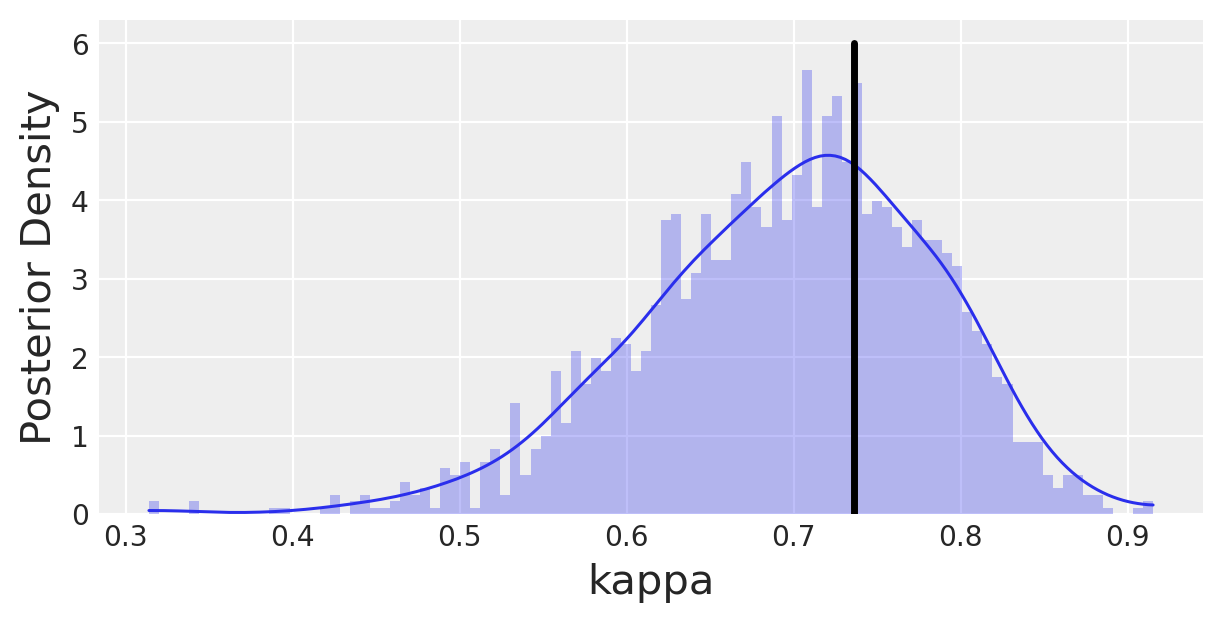

In [8]:
# Compare to Cohen's point estimate
n = y.sum()
p0 = (y[0] + y[3]) / n
pe = (((y[0] + y[1]) * (y[0] + y[2])) + ((y[1] + y[3]) * (y[2] + y[3]))) / n ** 2
kappa_Cohen = (p0 - pe) / (1 - pe)

kappa = trace3["kappa"]

_, axes = plt.subplots(1, 1, figsize=(6, 3))
az.plot_kde(kappa, ax=axes)
axes.hist(kappa, bins=100, density=1, alpha=0.3)
axes.plot([kappa_Cohen, kappa_Cohen], [0, 6], "k", lw=2.5)
axes.set_xlabel("kappa")
axes.set_ylabel("Posterior Density")

print("Cohen's point estimate: %.3f" % kappa_Cohen)
print("MCMC estimate: %.3f" % np.mean(kappa))

## 5.4 Change detection in time series data
  
Detecting a single change point in time series.

$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \lambda \sim \text{Gamma} (.001, .001)  $$
$$ \tau \sim \text{Uniform} (0, t_{max}) $$  
$$   c_{i} \sim
\begin{cases}
\text{Gaussian}(\mu_{1}, \lambda),  & \text{if $t_{i} \lt \tau$} \\
\text{Gaussian}(\mu_{2}, \lambda),  & \text{if $t_{i} \ge \tau$}
\end{cases}  $$

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambd, mu]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 10000/10000 [00:12<00:00, 809.70draws/s]
The number of effective samples is smaller than 25% for some parameters.


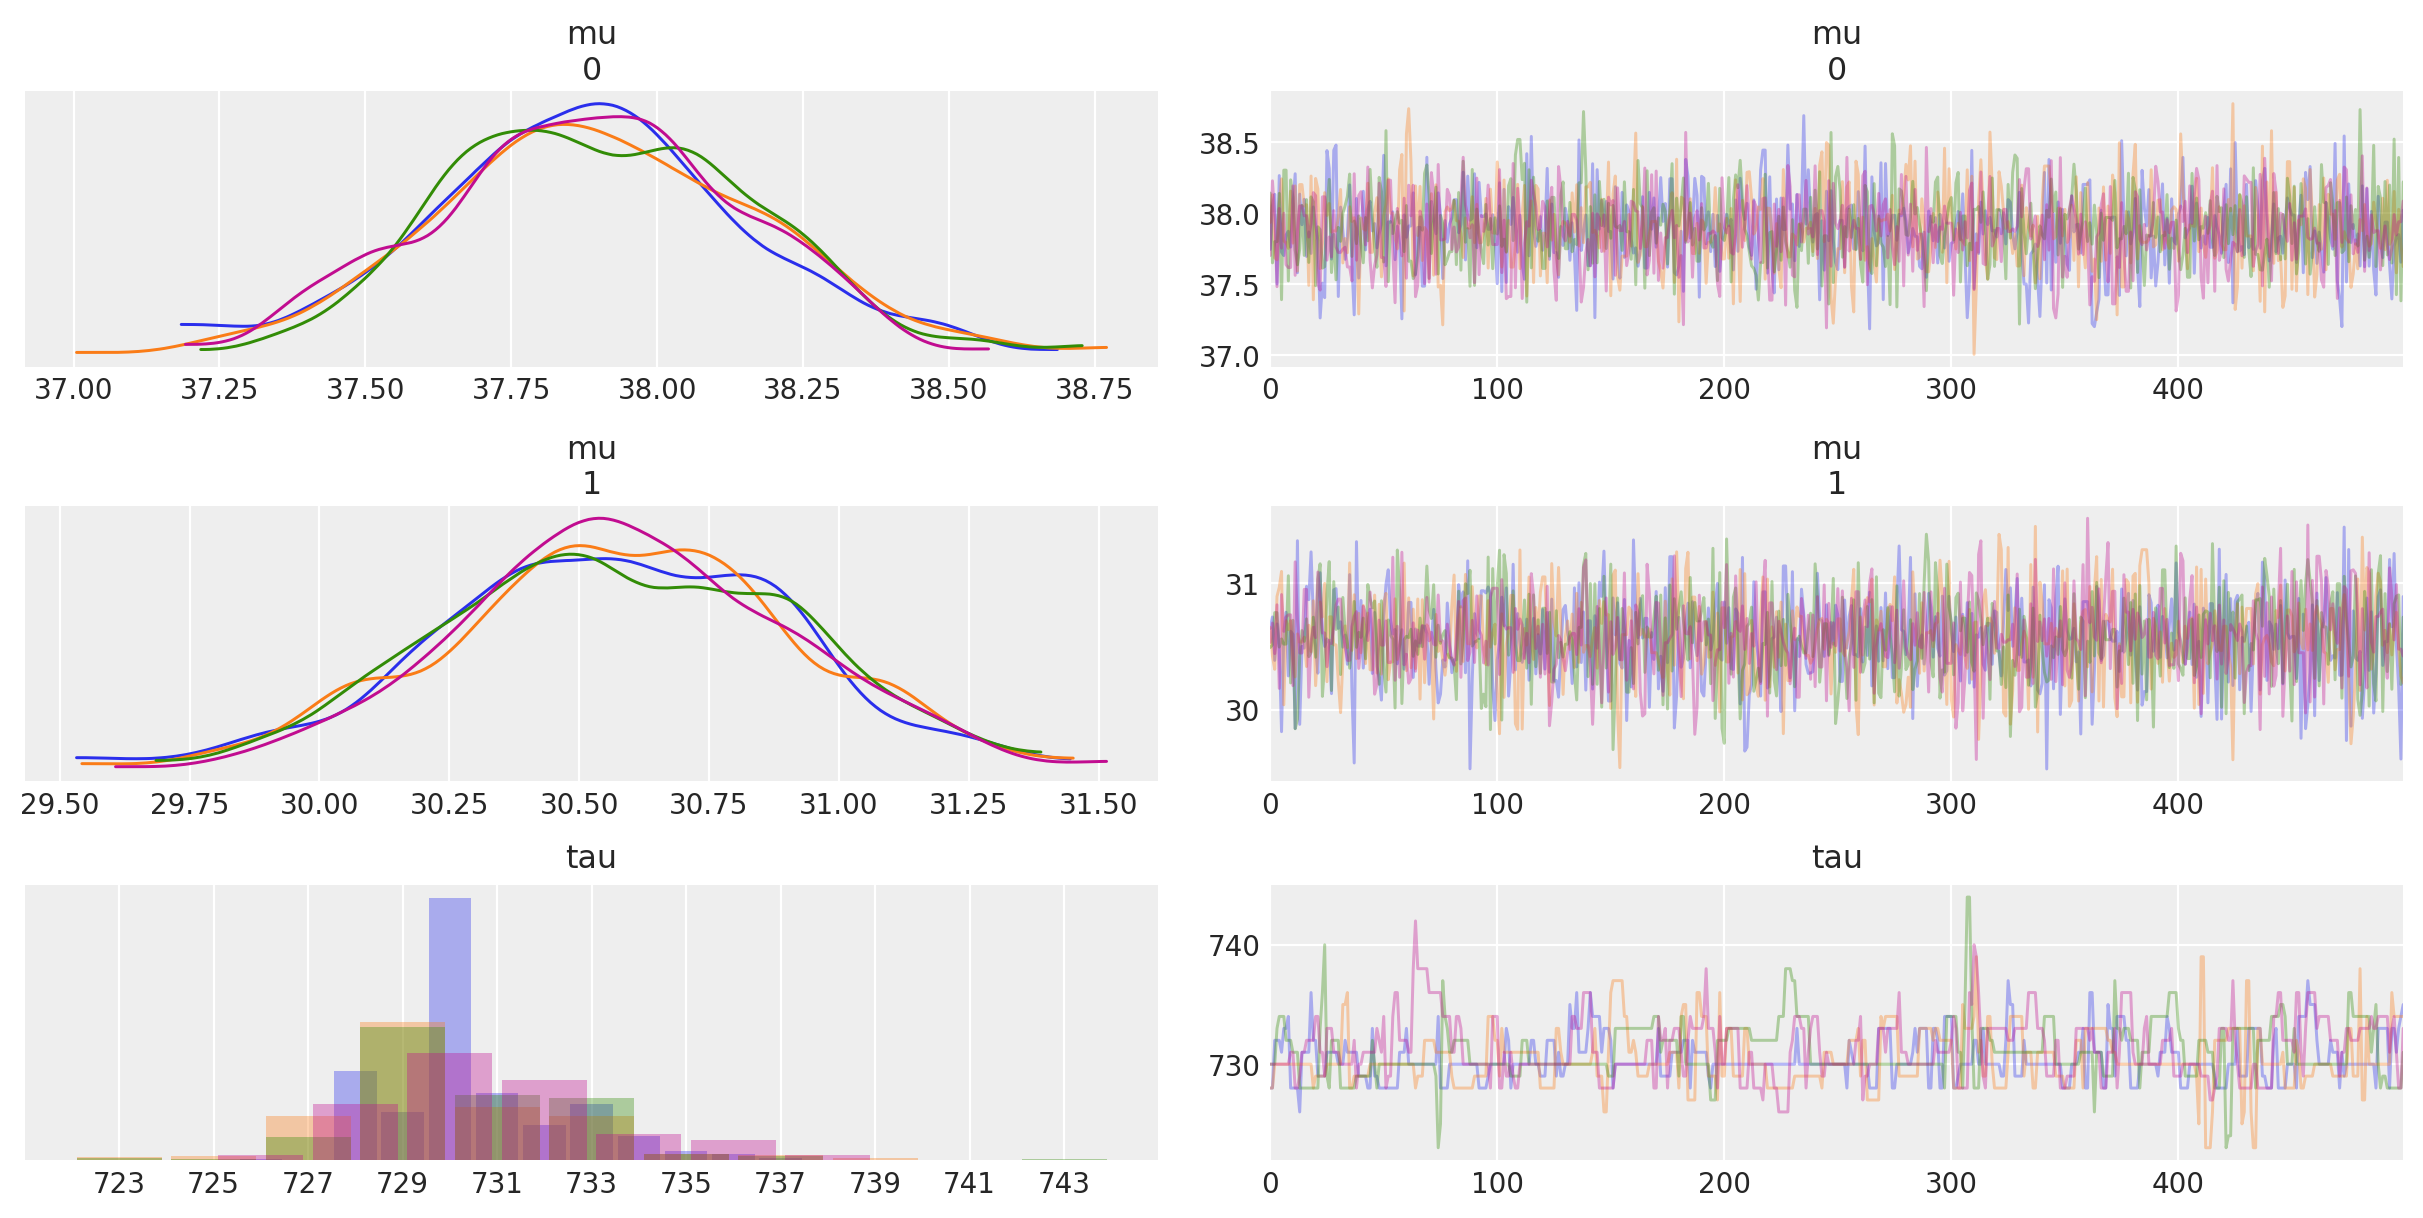

In [9]:
# Load data
dat = pd.read_csv("changepointdata.csv")

c = dat.data
n = np.size(c)
sample = np.arange(0, n)

with pm.Model() as model4:
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal("mu", mu=0, tau=0.001, shape=2)
    # λ∼Gamma(.001,.001)
    lambd = pm.Gamma("lambd", alpha=0.001, beta=0.001)
    # τ∼Uniform(0,tmax)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n)

    muvect = pm.math.switch(tau >= sample, mu[0], mu[1])
    cobs = pm.Normal("cobs", mu=muvect, tau=lambd, observed=c)

    trace4 = pm.sample(tune=2000)

az.plot_trace(trace4, var_names=["mu", "tau"]);

In [10]:
az.summary(trace4)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu[0]   37.888  0.264   37.377   38.349      0.005    0.004    2427.0  2425.0   
mu[1]   30.571  0.327   29.969   31.189      0.006    0.004    2849.0  2849.0   
tau    730.827  2.298  726.000  734.000      0.127    0.090     326.0   325.0   
lambd    0.021  0.001    0.020    0.023      0.000    0.000    2878.0  2878.0   

       ess_bulk  ess_tail  r_hat  
mu[0]    2422.0    1517.0   1.00  
mu[1]    2819.0    1543.0   1.00  
tau       342.0     459.0   1.03  
lambd    2816.0    1410.0   1.00

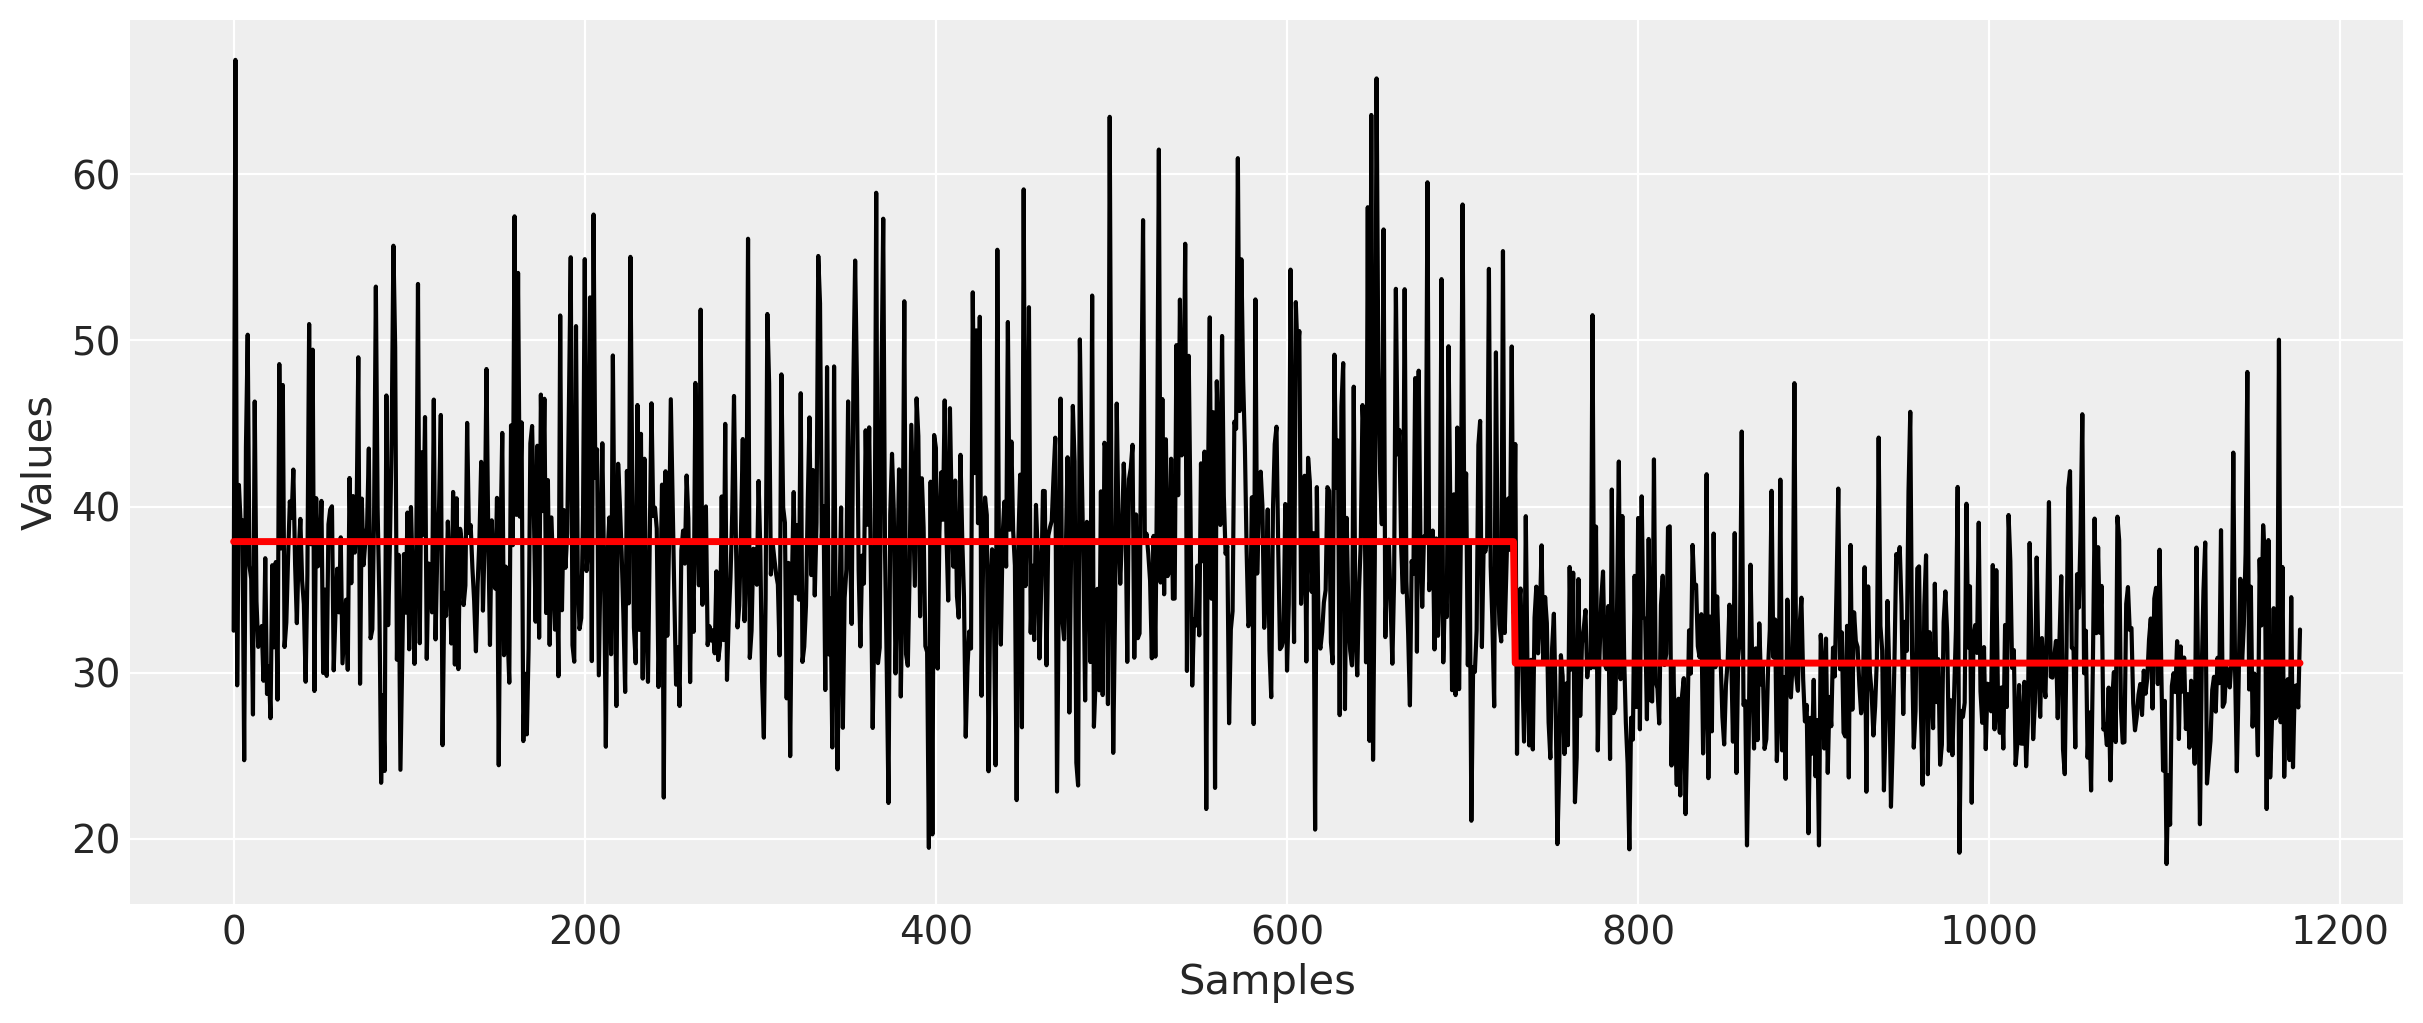

In [11]:
MCtau = trace4["tau"]
MCmu = trace4["mu"]

mu1 = np.mean(MCmu, axis=0)
tau1 = int(np.mean(MCtau))
fited = np.zeros(n)
fited[:tau1] = np.ones(tau1) * mu1[0]
fited[tau1:] = np.ones(n - tau1) * mu1[1]

_, axes = plt.subplots(1, 1, figsize=(12, 5))
axes.plot(np.arange(0, n, 1), c, color="k")
axes.plot(np.arange(0, n, 1), fited, color="r", lw=2.5)
axes.set_xlabel("Samples")
axes.set_ylabel("Values");

## 5.5 Censored data

After 949 failed attempts, Cha Sa-Soon from Korea finally passed her theoretical drivers exam. What can we infer about theta, the probability of answering any one question correctly?

$$ \theta \sim \text{Uniform}(0.25, 1) $$
$$ z_{i} \sim \text{Binomial}(\theta, n) $$
$$ 15 \le z_{i} \le 25, \text{if} \; y_{i} = 1 $$ 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████| 6000/6000 [00:03<00:00, 1867.26it/s]
The acceptance probability does not match the target. It is 0.8804651443280107, but should be close to 0.8. Try to increase the number of tuning steps.


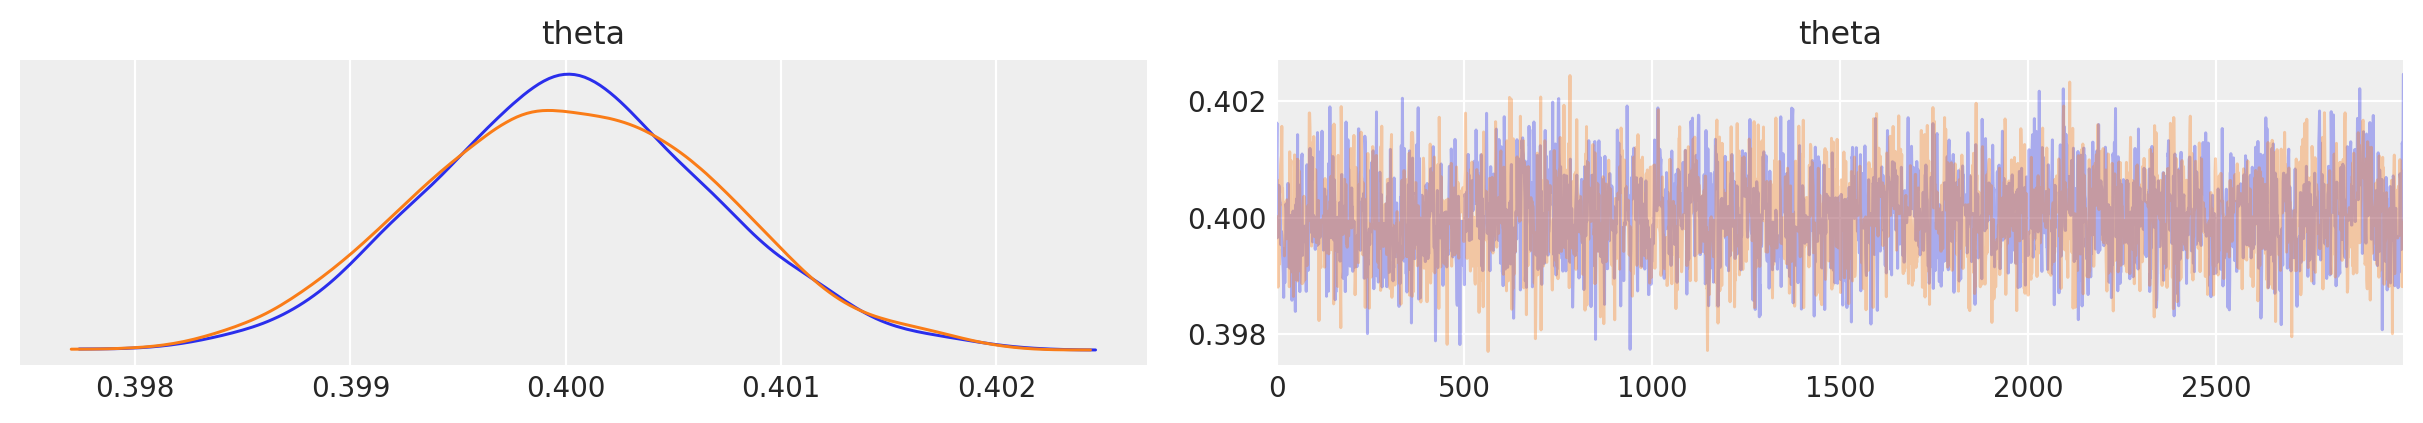

In [12]:
nattempts = 950
nfails = 949
n = 50  # Number of questions
y = np.zeros(nattempts)
y[nattempts - 1] = 1
z = 30
unobsmin = 15
unobsmax = 25
unobsrange = np.arange(unobsmin, unobsmax + 1)


def logp(value, n, p):
    return pm.distributions.dist_math.bound(
        pm.distributions.dist_math.binomln(n, value)
        + pm.distributions.dist_math.logpow(p, value)
        + pm.distributions.dist_math.logpow(1 - p, n - value),
        0 <= value, value <= n, 0 <= p, p <= 1)


def Censorlike(value=z, n=n, censorn=nfails, unobs=unobsrange):
    ylikeobs = logp(value=value, n=n, p=theta)
    ylikeunobs = 0
    for i in unobs:
        ylikeunobs += logp(value=i, n=n, p=theta)
    return ylikeobs + ylikeunobs * censorn


with pm.Model() as model5:
    theta = pm.Uniform("theta", lower=0.25, upper=1)
    ylike = pm.DensityDist("ylike" ,Censorlike, 
                           observed={"value": z, "n": n, "censorn": nfails, "unobs": unobsrange})
    trace5 = pm.sample(3000, tune=3000,  cores=1) # cores=1 in windows

az.plot_trace(trace5);

## 5.6 Recapturing planes

$$ k \sim \text{Hypergeometric}(n, x, t) $$ 
$$ t  \sim \text{Categorical}(\alpha) $$ 

In [13]:
x = 10  # number of captures
k = 4  # number of recaptures from n
n = 5  # size of second sample
tmax = 50  # maximum population size

factln = pm.distributions.dist_math.factln

with pm.Model() as model7:
    tau = pm.DiscreteUniform("tau", lower=x + (n - k), upper=tmax)
    
    logterm1 = factln(x + 0.01) - factln(k + 0.01) - factln(x - k + 0.01)
    logterm2 = (factln(tau - x + 0.01)
        - factln(n - k + 0.01)
        - factln((tau - x) - (n - k) + 0.01))
    logterm3 = factln(tau + 0.01) - factln(n + 0.01) - factln(tau - n + 0.01)
    C = 1000
    phi = -(logterm1 + logterm2 - logterm3) + C

    obs = pm.Poisson("obs", mu=phi, observed=0)
    trace7 = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 4000/4000 [00:05<00:00, 717.77draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


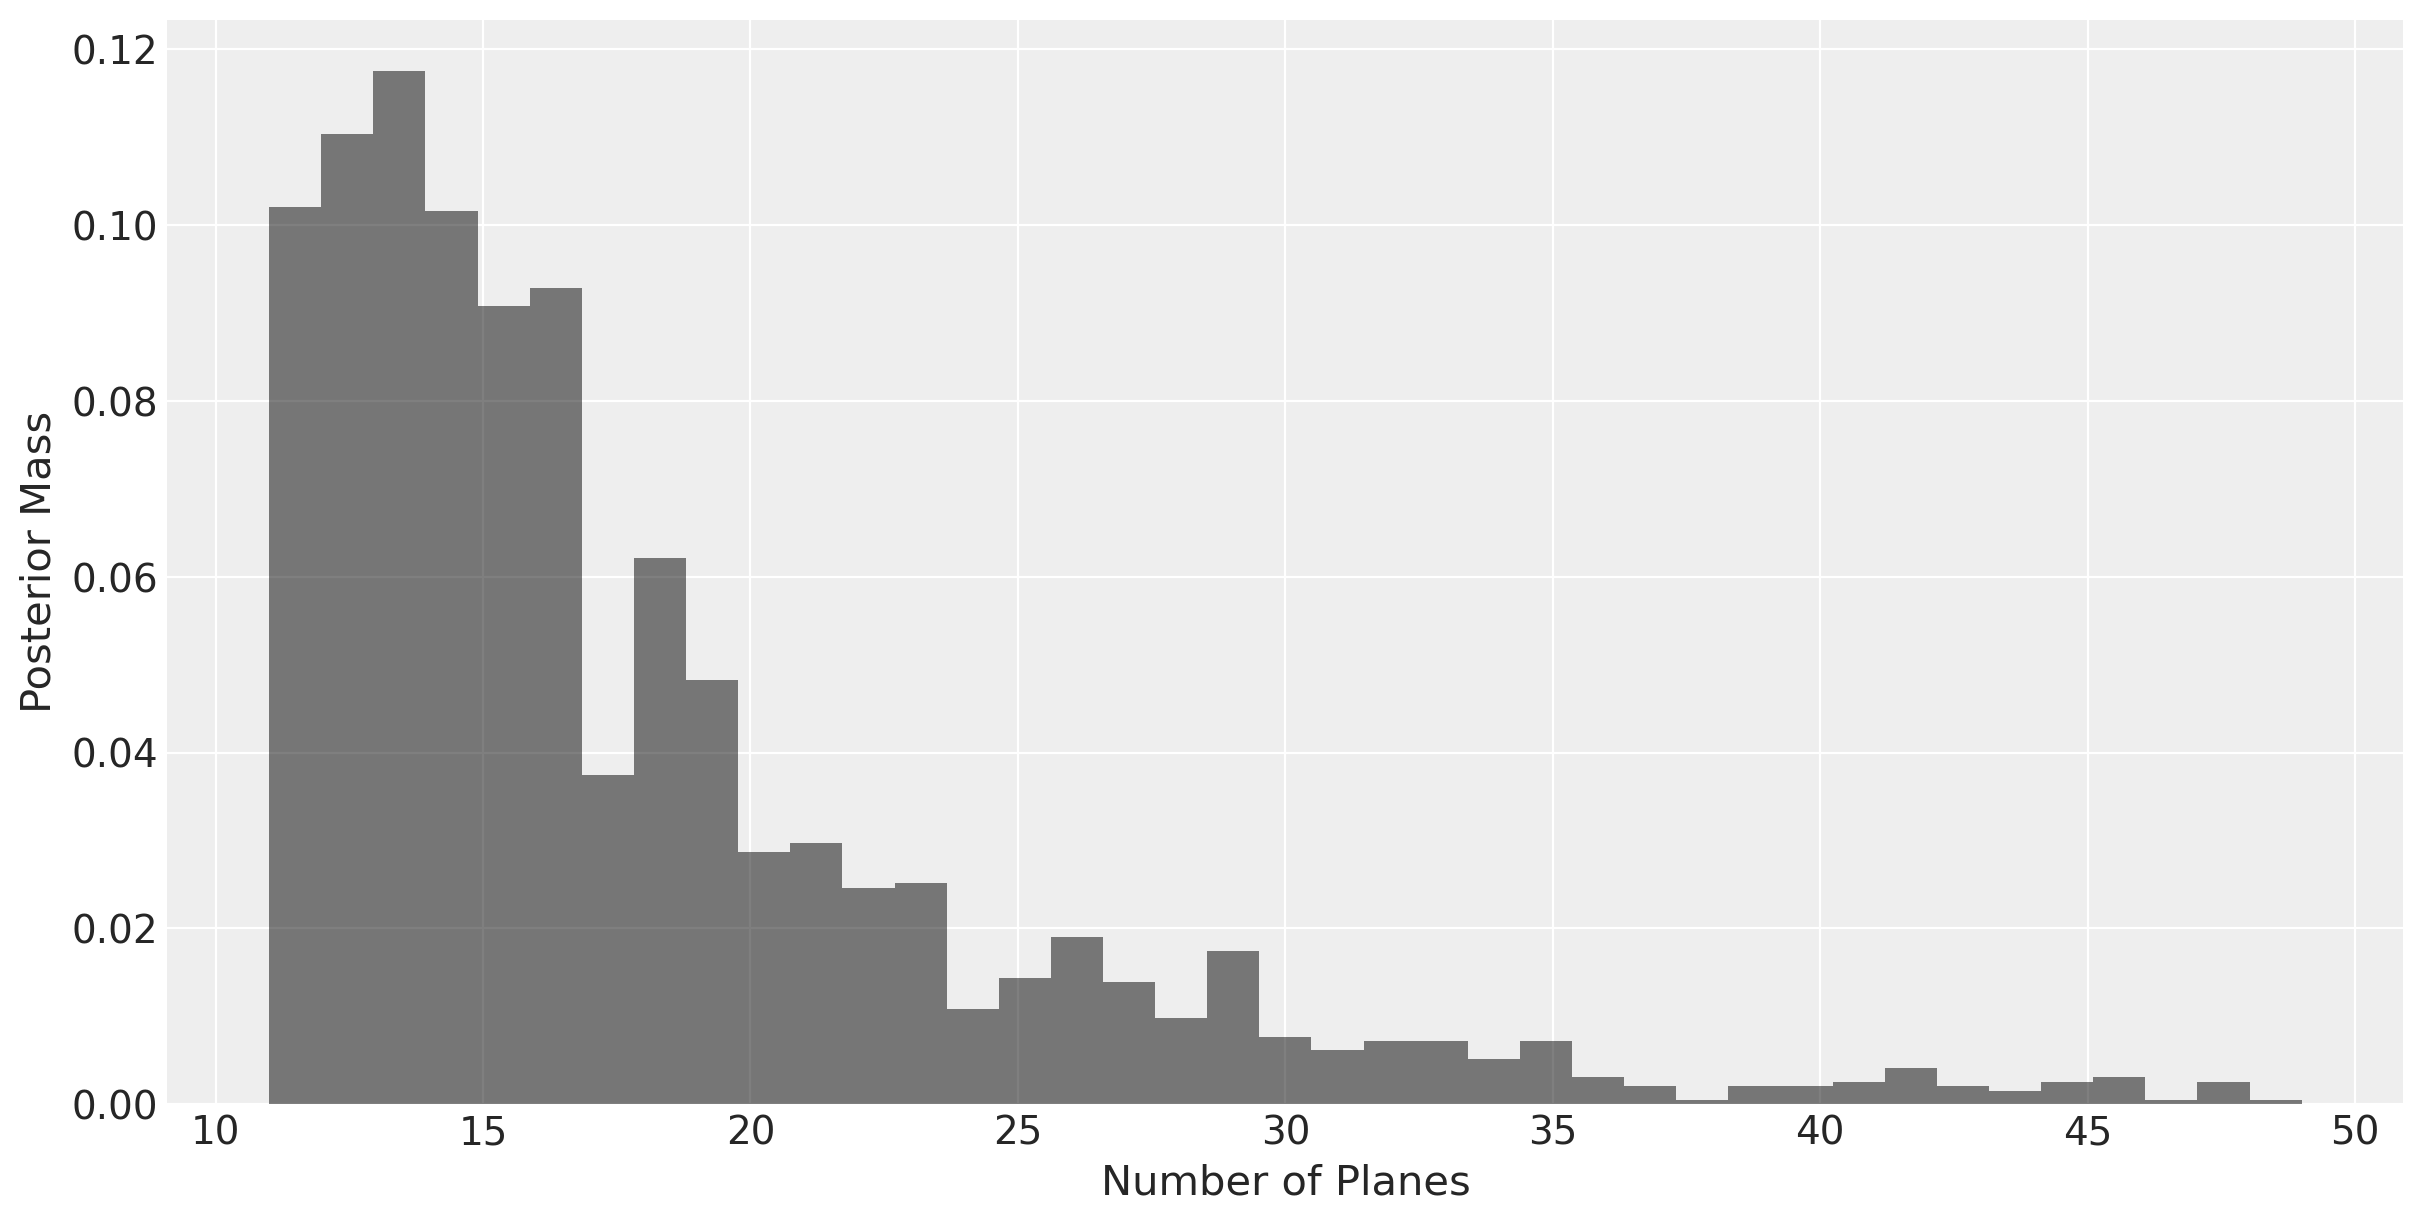

In [14]:
tau = trace7["tau"]

plt.figure(figsize=(12, 6))
plt.hist(tau, bins=tmax - (x + (n - k)), density=1, alpha=0.5, color="k")
plt.xlabel("Number of Planes")
plt.ylabel("Posterior Mass");

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas 0.25.3
pymc3  3.8
arviz  0.7.0
numpy  1.17.3
last updated: Fri Apr 24 2020 

CPython 3.7.0
IPython 7.12.0
watermark 2.0.2
